# Query the ADAPT NGA ESRI GeoDataBase
return a subset geopandas dataframe of the footprints of interest

In [1]:
import pandas as pd
import geopandas as gpd
import os
import maplib
import fiona

/tmp/ipykernel_1456507/2279470457.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
!pip install utm

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install folium

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import folium
from folium import Map, TileLayer, GeoJson, LayerControl, Icon, Marker, features, Figure, CircleMarker, plugins
# This is for this:
# https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.from_postgis.html
#from sqlalchemy import create_engine  
!pip install psycopg2

Defaulting to user installation because normal site-packages is not writeable


##### This function to query the postgres database using SQL is NOT used here. Included for reference only.

In [3]:
# #import psycopg2  # <-- not installed
# def query_db_catid_NEW(catID, prod_code='M1BS', out_dir='/explore/nobackup/people/pmontesa', db_table='nga_footprint_master_V2'):
#     '''Query and select scenes from latest database
#     '''
#     with psycopg2.connect(database="arcgis", user="pmontesa", 
host="arcdb04", port="5432") as dbConnect:

#         cur = dbConnect.cursor() # setup the cursor
#         selquery =  "SELECT S_FILEPATH, SENSOR, CATALOG_ID, ACQ_TIME FROM %s WHERE CATALOG_ID = '%s' AND PROD_CODE = '%s'" %(db_table, catID, prod_code)
#         #selquery =  "SELECT * FROM %s WHERE CATALOG_ID = '%s' AND PROD_CODE = '%s'" %(db_table, catID, prod_code)
#         cur.execute(selquery)
#         selected=cur.fetchall()

#     return selected

#### Identify the ESRI Geodatabase of interest

In [5]:
nga_gdb_fn = '/css/nga/INDEX/current/nga_footprint.gdb'
fiona.listlayers(nga_gdb_fn)

['nga_footprint_archive_v2', 'nga_footprint_master_v2']

#### Read in 1 row to list the columns of the GDB
- build a list of columns that you'll want to ignore when you read in the entire database - to keep memory usage low

In [6]:
# a tmp file of 1 row to get the col names of the gdb
nga_gdb_tmp = gpd.read_file(nga_gdb_fn, rows=1, layer='nga_footprint_master_v2')
print(nga_gdb_tmp.columns)
keep_col_list = ['s_filename', 'catalog_id']
rm_col_list = nga_gdb_tmp.columns.difference(keep_col_list).tolist()

Index(['fpuid', 'strip_id', 'scene_id', 'status', 'catalog_id', 'order_id',
       'prod_code', 'country', 'spec_type', 'acq_time', 'cloudcover',
       'cent_lat', 'cent_long', 'columns', 'rows', 'bits_pixel', 'file_fmt',
       'off_nadir', 'sun_elev', 'prod_gsd', 'ref_height', 'xtrackva',
       's_filename', 's_filepath', 'sensor', 'bands', 'previewjpg',
       'previewurl', 'added_date', 'file_sz', 'avsunazim', 'avtargetaz',
       'stereopair', 'pairname', 'acq_date', 'acq_year', 'prod_short',
       'det_pitch', 'intrackva', 'acq_month', 'zone_id', 'source',
       'shape_Length', 'shape_Area', 'geometry'],
      dtype='object')


#### Read in the Geodatabase and return just the columns you specified above

In [7]:
%%time
nga_gdb = gpd.read_file(nga_gdb_fn, layer='nga_footprint_master_v2') #ignore_fields = rm_col_list, 
nga_gdb.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24841010 entries, 0 to 24841009
Data columns (total 45 columns):
 #   Column        Dtype              
---  ------        -----              
 0   fpuid         object             
 1   strip_id      object             
 2   scene_id      object             
 3   status        object             
 4   catalog_id    object             
 5   order_id      object             
 6   prod_code     object             
 7   country       object             
 8   spec_type     object             
 9   acq_time      object             
 10  cloudcover    float64            
 11  cent_lat      float64            
 12  cent_long     float64            
 13  columns       int64              
 14  rows          int64              
 15  bits_pixel    int64              
 16  file_fmt      object             
 17  off_nadir     float64            
 18  sun_elev      float64            
 19  prod_gsd      float64            
 20  ref_height    

# Subset the NGAdb

#### Subset using a list of scenes names that we want footprints for

In [9]:
if False:
    # The csv filename (fn) of the input raster (ntf scenes) file names...
    r_fn_csv_fn = '/att/nobackup/pmontesa/userfs02/projects/srlite/misc/potential_scenes_4_srlite.csv'
    r_fn_df = pd.read_csv(r_fn_csv_fn)
    filename_search_list = [os.path.basename(f) for f in list(set(r_fn_df.path))]
    subset_gdf = nga_gdb[nga_gdb['s_filename'].isin(filename_search_list)]

#### Subset to the TTE

In [51]:
if True:
    tte_patterns_fn = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/boreal_height_cmip/hydrobasins_L08_patterns_tte.gpkg'
    tte_patterns = gpd.read_file(tte_patterns_fn)
    tte_patterns_abrupt = tte_patterns[(tte_patterns.pattern_class == 'TTE abrupt') | (tte_patterns.pattern_class == 'TTE abrupt (edge)')]

    # Buffer the ecotone in units of meters (requires a reproj)
    BUF_SZ_M = 100e3 #km
    geom_buf = tte_patterns_abrupt.to_crs(3338).dissolve(by='cavm').iloc[0].geometry.buffer(BUF_SZ_M)
    # Reproj back to GCS before spatial query with large ngadb
    select_gdf = gpd.GeoDataFrame(index=[0], geometry=[geom_buf], crs=3338)
    # selector = nga_gdb.intersects(select_gdf)
    # subset_gdf = nga_gdb[selector]
    # subset_gdf.info()

<AxesSubplot: >

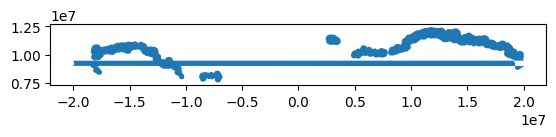

In [53]:
select_gdf.to_crs(3857).plot()

In [ ]:
# copy GeoDataFrame
points = nga_gdb.cx[-180:180, 45:85].sample(frac=0.1).copy()

/tmp/ipykernel_1456507/463552033.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points['geometry'] = points['geometry'].centroid


<AxesSubplot: >

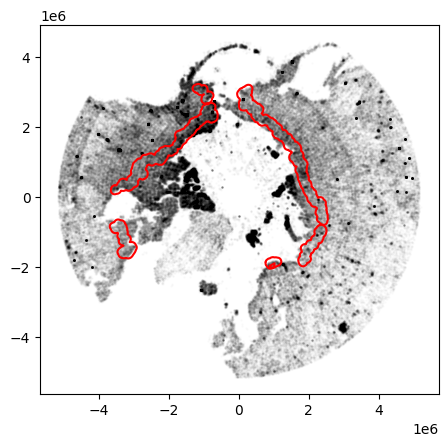

In [35]:
# change geometry 
points['geometry'] = points['geometry'].centroid
ax = points[points.prod_code == 'M1BS'].to_crs(3995).plot(alpha=0.01, markersize=1, color='black')
select_gdf.boundary.cx[-180:180, 45:85].to_crs(3995).plot(ec='red', ax=ax)

<AxesSubplot: >

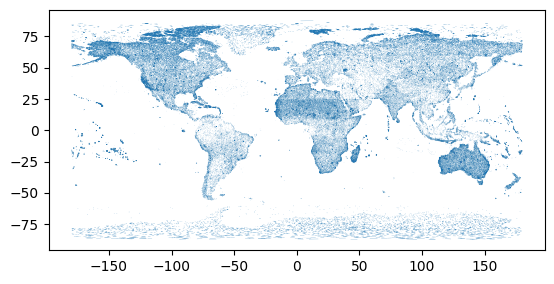

In [37]:
nga_gdb.sample(frac=0.01).plot()

<AxesSubplot: >

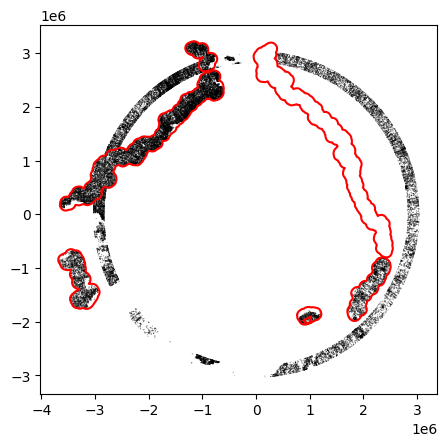

In [50]:
subset_gdf = gpd.overlay(nga_gdb.sample(frac=0.1), select_gdf)
ax = subset_gdf[subset_gdf.prod_code == 'M1BS'].to_crs(3995).plot(alpha=0.5, color='black')
select_gdf.boundary.cx[-180:180, 45:85].to_crs(3995).plot(ec='red', ax=ax)

In [43]:
selector = select_gdf.intersects(points)
subset_gdf = select_gdf[selector]
subset_gdf.info()

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 0 entries
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  0 non-null      geometry
dtypes: geometry(1)
memory usage: 0.0 bytes


/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


### Map the subset of NGA scenes

In [22]:
m = maplib.MAP_LAYER_FOLIUM(LAYER = subset_gdf, lat_start = subset_gdf.geometry.centroid.y.mean(), lon_start = subset_gdf.geometry.centroid.x.mean() )
m

<ipython-input-22-eafa9a63cf1b>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = maplib.MAP_LAYER_FOLIUM(LAYER = subset_gdf, lat_start = subset_gdf.geometry.centroid.y.mean(), lon_start = subset_gdf.geometry.centroid.x.mean() )


#### Write subset data frame of footprints to geopackage

In [ ]:
import utm
for idx, row in subset_gdf.iterrows():

    c = row.geometry.centroid
    
    utm_x, utm_y, band, zone = utm.from_latlon(c.y, c.x) 
    
    if c.y > 0: # Northern zone
        epsg = 32600 + band
    else:
        epsg = 32700 + band
        
    subset_gdf.loc[idx,'utm_zone'] = int(band)
    subset_gdf.loc[idx,'epsg'] = int(epsg)

In [310]:
subset_gdf.to_file(os.path.splitext(r_fn_csv_fn)[0] + '.gpkg', driver='GPKG', layer='name', crs=4326) 
subset_gdf.to_file(os.path.splitext(r_fn_csv_fn)[0] + '.shp', driver='ESRI Shapefile', layer='name', crs=4326) 

#### Set up multiple bbox's

In [48]:
#bbox_serc = tuple([-76, 38, -75.5, 38.1])

bbox_ykd = [-165, 60, -162, 65]
bbox_sib = tuple([100, 65, 110, 70])

bbox_serc = tuple([-76.5627, 38.8903, -76.5555, 38.8957])
bbox_howland = tuple([-68.748274, 45.197211, -68.738740, 45.204889])
bbox_whitesands = tuple([-106.344218, 32.916644, -106.336254, 32.922880])
bbox_laselva =tuple([-84.010332, 10.426897, -84.002446, 10.434296])
SITES_BBOX_LIST = [bbox_serc, bbox_howland, bbox_whitesands, bbox_laselva] #, bbox_ykd, bbox_sib]
SITES_NAME_LIST = ['SERC', 'Howland', 'White Sands', 'La Selva']#, 'YK Delta', 'Siberia']

SITES_DICT = dict(zip(SITES_NAME_LIST, SITES_BBOX_LIST))

#### Subset by bounding box

In [ ]:
xmin, ymin, xmax, ymax = bbox_ykd
z = subset_gdf.cx[xmin:xmax, ymin:ymax]
m = maplib.MAP_LAYER_FOLIUM(LAYER = z, lat_start = z.geometry.centroid.y.mean(), lon_start = z.geometry.centroid.x.mean() )
m

##### Query the geodatabase with a spatial index using multiple bbox's.
use a bulk query with an optional predicate; predicate = 'contains'
https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.sindex.html#geopandas-geoseries-sindex

In [51]:
%%time
from folium import plugins
import shapely.geometry
BBOX_SERIES = gpd.GeoSeries([shapely.geometry.box(*bbox) for bbox in SITES_BBOX_LIST])

nga_gdb.sindex.query_bulk(BBOX_SERIES)

# index 1 returns what you want
z = nga_gdb.loc[nga_gdb.sindex.query_bulk(BBOX_SERIES)[1]]

print(z.shape)
#print(nga_gdb.sindex.query_bulk(BBOX_SERIES)[1])

m = maplib.MAP_LAYER_FOLIUM(LAYER = z.sample(frac=1), lat_start = z.geometry.centroid.y.mean(), lon_start = z.geometry.centroid.x.mean() ).add_child(plugins.MeasureControl()).add_child(plugins.Fullscreen())
m


(617, 45)


<timed exec>:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



CPU times: user 296 ms, sys: 50 ms, total: 346 ms
Wall time: 341 ms


#### Get SERC nga data for EVHR

In [72]:
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
z.s_filepath.to_csv(f'/att/nobackup/pmontesa/userfs02/projects/srlite/misc/nga_gdb_bbox_scenes_{nowtime}.csv')
z.shape

(617, 45)

In [42]:
z.cx[-76.5627:-76.5555, 38.8903:38.8957].shape
z.cx[-76.5627:-76.5555, 38.8903:38.8957].groupby('sun_elev')['catalog_id'].agg(['count'])

,count
sun_elev,
25.6,2
25.8,4
25.9,3
26.5,1
26.6,3
...,...
69.0,6
69.3,3
69.5,2


##### Example: see a footprint of all scenes of a given CATID

In [ ]:
search_list = ["1050010016726200"]
nga_gdb[nga_gdb['catalog_id'].isin(search_list)].plot()

##### Example: another style of searching with a list and plotting the result

In [ ]:
search_list = ['GE01_20190528002848_1050010016726200_19MAY28002848-M1BS-503250033040_01_P003.ntf']
nga_gdb.query('s_filename in @search_list').plot()